# Определение стоимости автомобилей

**Цель исследования** - Разработка системы рекомендации стоимости автомобиля на основе его описания.

**Датафрейм:** Исторические данные сервиса по продаже автомобилей с пробегом. 

**План работы:**
1. Импорт данных.
2. Изучение и предобрабокта.
3. Подготовка выборки для обучения.
4. Обучение моделей.
5. Анализ моделей.
6. Вывод.

## Импорт данных:

In [1]:
# Импортируем библиоотеки:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import time 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)


from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
!pip install scikit-learn==1.1.3

from catboost import CatBoostRegressor, Pool

warnings.filterwarnings("ignore")

RND = 12345


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

## Изучение и предобработка данных:

Изучу данные на предмет пропусков, дубликатов, изучу столбцы на информативность.

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Месяц регистрации автомобиля, количество фотографий автомобиля, и дата последней активности пользователя, дата скачивания анкеты из базы, дата создания анкеты - это неинформативные столбцы, на цене весомо не сказываются, а вот качество этих данных может страдать, и скорость работы модели также будет замедляться.

In [7]:
# Удалим неинформативные столбцы:
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

In [8]:
# Проверим результат:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [9]:
# Проверим датасет на дубликаты:
df.duplicated().sum()

27543

В датасете из данных в 354368 строк 19 дубликатов, попробую их удалить и проверить метрики качества. Если все норм, то оставлю удаление.

In [10]:
# Удаляем дубликаты:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

In [12]:
# Проверим нулевые значения: 
df.isna().sum()

Price                    0
VehicleType          35249
RegistrationYear         0
Gearbox              17578
Power                    0
Model                18532
Kilometer                0
RegistrationMonth        0
FuelType             31122
Brand                    0
Repaired             66427
dtype: int64

Обработаю каждый столбец отдельно:

In [13]:
# Посмотрю уникальные значения отдельно столбца:
df.VehicleType.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Считаю абсолютно неверным строки с пропусками в этом столбце, потому что это будет огромная потеря данных, но и заменить не на что, единственно возможный вариант из известных нам - это заглушка, поставлю заглушку.

In [14]:
# Заменю все пропуски в этом стобце на nan:
df['VehicleType']=df['VehicleType'].fillna('other')

In [15]:
# Проверка:
df.VehicleType.isna().sum()

0

Проделаю то же самое со столбцом FuelType:

In [16]:
df.FuelType.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [17]:
df.FuelType.value_counts()

FuelType
petrol      200260
gasoline     89464
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: count, dtype: int64

Эти данные также очень важны для ценообразования, и пропуски в огромном количестве, поэтому тоже поставлю заглушку.

In [18]:
df['FuelType']=df['FuelType'].fillna('nan')

In [19]:
df.FuelType.isna().sum()

0

И ровно то же самое сделаю со столбцом Repaired, просто не хочется терять такаой огромный массив данных.

In [20]:
df['Repaired']=df['Repaired'].fillna('nan')

In [21]:
df.Repaired.isna().sum()

0

Что касается пропусков в столбцах модель и тип коробки передач - пропусков здесь не критически много, а эти признаки на ценообразование влияют прямолинейно, поэтому здесь рискнем удалить столбцы с пропусками. Все проверим на метриках качества после.

In [22]:
df.dropna(subset=['Gearbox'], inplace=True)
df.dropna(subset=['Model'], inplace=True)

In [23]:
# Финальная провверка по пропускам:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294249 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              294249 non-null  int64 
 1   VehicleType        294249 non-null  object
 2   RegistrationYear   294249 non-null  int64 
 3   Gearbox            294249 non-null  object
 4   Power              294249 non-null  int64 
 5   Model              294249 non-null  object
 6   Kilometer          294249 non-null  int64 
 7   RegistrationMonth  294249 non-null  int64 
 8   FuelType           294249 non-null  object
 9   Brand              294249 non-null  object
 10  Repaired           294249 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.9+ MB


In [25]:
#изучим датасет, определим, какие столбцы нуждаются в анализе на выбросы:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,294249.000000,294249.000000,294249.000000,294249.000000,294249.000000
mean,4589.428134,2003.395063,114.783343,128804.023123,5.886260
std,4565.873196,30.397166,191.514785,36687.184148,3.638556
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6600.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000


В Power присутствуют аномальные значения (20 000). Значения из столбца Price обладают высоким стандартным отклонениям - изучим эти столбцы на выбросы.

Также очень странные значения года регистрации, и в месяце есть нули, можно заменить нули на единицу, а год регистрации ограничить интервалом.

In [26]:
#Создам функцию для ограничения RegistrationYear:
def RegistrationYear(value):
    if value > 2016:
        return 2016
    elif value < 1970:
        return 1970
    else:
        return value
df["RegistrationYear"] = df["RegistrationYear"].apply(RegistrationYear)
# RegistrationMonth
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

Если метрики качества нас не удовлетворят, вернусь к этой ячейке, возможно нужен другой интервал года.

Для анализа данных в столбце прайс на выбросы использую ящик с усами:

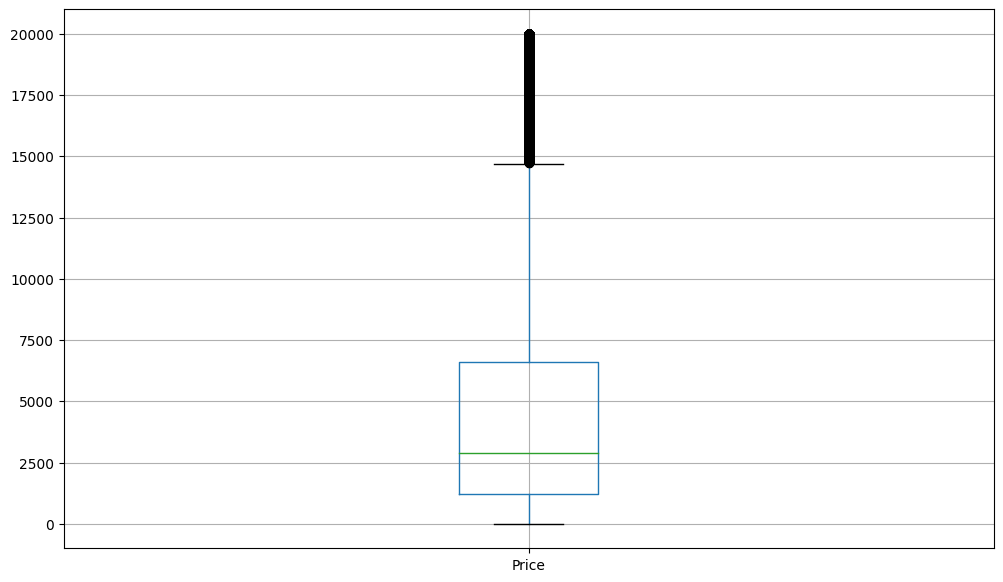

In [27]:
df.boxplot(['Price'],figsize=(12,7))

plt.show()

In [28]:
#Можно удалить значения  меньше 10, это неадекватная цена для евро:
df = df.query('Price> 10')

In [29]:
#Посмотрю на пауэр через квантили:
quantile_1 = df['Power'].quantile(0.25)
quantile_3 = df['Power'].quantile(0.75)
IQR = quantile_3 - quantile_1
fig, ax = plt.subplots()
df['Power'].plot(kind = 'hist', bins = 100, grid = True, range = (quantile_1 - IQR, quantile_3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('ЛС')
ax.set_ylabel('кол-во')

Text(0, 0.5, 'кол-во')

In [30]:
#Судя по графику, выбросы по максимум можно убрать ограничив ЛС до 320 ЛС:
df = df.query('Power <= 320')

In [31]:
#Финальная проверка:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,285225.000000,285225.000000,285225.000000,285225.000000,285225.000000
mean,4664.324719,2003.240207,110.181050,128697.361732,5.990618
std,4529.142530,6.748853,57.127451,36595.228002,3.510524
min,11.000000,1970.000000,0.000000,5000.000000,1.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2995.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6700.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,2016.000000,320.000000,150000.000000,12.000000


## Подготовка выборки для обучения моделей:


Проведу масштабирование:

In [32]:
#Разделю датасет на фичи и таргет:
features = df.drop('Price', axis=1)
target = df['Price']

In [33]:
# Разделю фичи на тест и трэйн:
train_features, test_features, train_target, test_target = train_test_split(features, target,
                                                                                                test_size = 0.25,
                                                                                                random_state = 42)

In [34]:
ohe_features_lin = train_features.select_dtypes(include='object').columns.to_list()
print(ohe_features_lin)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [35]:
num_features = train_features.select_dtypes(exclude='object').columns.to_list()
num_features

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [36]:
X_train_lin = train_features.copy()
X_test_lin = test_features.copy()

In [37]:
# признак repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough, чтобы он не пропал 
col_transformer_lin = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_lin
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# всё готово в пару строк кода
X_train_lin = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_lin.fit_transform(X_train_lin),
    columns=col_transformer_lin.get_feature_names_out()
)

# смотрим на результат
X_train_lin.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,...,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_yes,RegistrationYear,Power,Kilometer,RegistrationMonth
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.706661,1.048695,-1.057672,1.138803
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.706661,-0.176423,-0.784497,0.569254
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.183835,-0.613965,0.581379,0.854029
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.409829,0.926184,-0.101559,-1.139392
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.183835,-0.036409,0.581379,-0.854617


Ниже с выборкой для LightGBM я поработала.

Отлично, с предобработкой данных закончили. К этому этапу буду возвращаться по мере необходимости, отталкиваясь от качества предсказаний модели. 

## Обучение моделей:

Я попробую поискать лучшие RMSE при линейной регрессии, при градиентном бустинге с помощью CatBoost и LightGBM. + Рассчитаю везде время обучения и предсказания модели. 

In [38]:
# Но для начала напишу функцию для расчёта RMSE:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5)

In [39]:
%%time
start = time.time()
model_1=LinearRegression()
model_1.fit(X_train_lin,train_target)
end = time.time()
t_1=round(end-start,2)


CPU times: total: 172 ms
Wall time: 3.29 s


In [40]:
%%time
start = time.time()
predict_1=model_1.predict(X_train_lin)
end = time.time()
t_1_p=round(end-start,2)

CPU times: total: 0 ns
Wall time: 34.2 ms


In [41]:
rmse_1 = rmse(train_target, predict_1)
print('RMSE модели Линейная Регрессия равна:', rmse_1)

RMSE модели Линейная Регрессия равна: 2583.7706899899977


Не совсем то, что нам нужно. Пойдем дальше.

In [42]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, cat_features=["VehicleType","Gearbox",
                                                             "Model","FuelType",
                                                             "Brand","Repaired"], verbose=10)
    print('Лучшие гиерпараметры: ', grid_cv.best_params_)
    print('RMSE: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [43]:
%%time
catb_params = catboost_regr(train_features, train_target)

Learning rate set to 0.5
0:	learn: 3071.5293552	total: 245ms	remaining: 24.2s
10:	learn: 1713.8936937	total: 1.15s	remaining: 9.3s
20:	learn: 1610.1770408	total: 2.03s	remaining: 7.63s
30:	learn: 1555.0544260	total: 2.9s	remaining: 6.46s
40:	learn: 1522.1927274	total: 3.77s	remaining: 5.43s
50:	learn: 1496.7755073	total: 4.66s	remaining: 4.47s
60:	learn: 1473.8097182	total: 5.54s	remaining: 3.54s
70:	learn: 1453.2425017	total: 6.42s	remaining: 2.62s
80:	learn: 1437.2555919	total: 7.29s	remaining: 1.71s
90:	learn: 1424.3156578	total: 8.17s	remaining: 808ms
99:	learn: 1410.4911384	total: 8.96s	remaining: 0us
Лучшие гиерпараметры:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE: 1602.88
CPU times: total: 5.7 s
Wall time: 49 s


In [44]:
%%time
start = time.time()
final_cat = CatBoostRegressor(max_depth= 10, n_estimators= 100, random_state= 12345, verbose= 0)
final_cat.fit(Pool(train_features,train_target,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"]))
end = time.time()
t_2=round(end-start,2)

CPU times: total: 5.59 s
Wall time: 9.1 s


In [45]:
%%time
start = time.time()
final_cat_pred = final_cat.predict(train_features)
rmse_2 = mse(train_target, final_cat_pred)**0.5
print('RMSE на тренировочной выборке равна: : {:.2f} '.format(rmse_2))
end = time.time()
t_2_p=round(end-start,2)

RMSE на тренировочной выборке равна: : 1417.78 
CPU times: total: 516 ms
Wall time: 458 ms


Очень даже хорошо, но посмотрим, что получится с LightGBM.

In [46]:
#Обработаем фичи для LightGBM:
X_train_light = train_features.copy()
X_test_light = test_features.copy()
X_train_light = X_train_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "Repaired":'category'})
X_test_light = X_test_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "Repaired":'category'})

In [47]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(X_train_light, target)
    print('Лучшие гиперпараметры: ', grid_cv.best_params_)
    print('RMSE на тренировочной выборке: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [48]:
%%time
lgb_params = lgb_regr(train_features, train_target)

Лучшие гиперпараметры:  {'max_depth': 10, 'n_estimators': 100}
RMSE на тренировочной выборке: 1601.40
CPU times: total: 4.98 s
Wall time: 5.63 s


In [49]:
%%time
start = time.time()
final_lgb = LGBMRegressor(max_depth=10, n_estimators=100)
final_lgb.fit(X_train_light, train_target, verbose=10, eval_metric='rmse')
end = time.time()
t_3=round(end-start,2)

CPU times: total: 5.86 s
Wall time: 559 ms


In [50]:
%%time
start = time.time()
predict_lgb = final_lgb.predict(X_train_light)
rmse_3 =mse(train_target, predict_lgb)**0.5
print('RMSE модели LightGBM на тестовых данных равна: = {:.2f}'.format(rmse_3))
end = time.time()
t_3_p=round(end-start,2)

RMSE модели LightGBM на тестовых данных равна: = 1538.94
CPU times: total: 2.58 s
Wall time: 252 ms


## Анализ моделей:


Создам общую наглядную таблицу для rmse, скорости обучения и скорости предсказания. 

In [52]:
column=['RMSE модели','Скорость обучения','Скорость предсказания']

comparison_tabl = pd.DataFrame(index=['RMSE модели','Скорость обучения', 'Скорость предсказания'], columns=['LinearRegression', 'CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = rmse_1, t_1, t_1_p
comparison_tabl['CatBoostRegressor'] = rmse_2, t_2, t_2_p
comparison_tabl['LightGBM'] = rmse_3, t_3, t_3_p

comparison_tabl.T.style.highlight_min(color='green',subset=column).highlight_null(color='grey').highlight_max(color='red',subset=column)

,RMSE модели,Скорость обучения,Скорость предсказания
LinearRegression,2583.770690,3.290000,0.030000
CatBoostRegressor,1417.777217,9.100000,0.460000
LightGBM,1538.939294,0.560000,0.250000


По качеству хороши 2 модели: катбуст, лайт. Но так как скорость обучения в 2 раза выше у лайт, выберу ее лучшей моделью. Проверим LightGBM на тестовой выборке.  

#### Опираясь на критерии заказчика, выберу лучшую модель, проверю её качество на тестовой выборке.

In [53]:
%%time
start = time.time()
predict_test= final_lgb.predict(X_test_light)
end = time.time()
t_test_p=round(end-start,2)


CPU times: total: 812 ms
Wall time: 127 ms


In [54]:
rmse_test = rmse(test_target, predict_test)
print('RMSE модели LightGBM на тестовых данных равна:', rmse_test)

RMSE модели LightGBM на тестовых данных равна: 1604.9419294317743


## Вывод:

Я подготовила данные для дальнейшей работы с ними: заменила пропуски, удалила неинформативные столбцы, удалила дубликаты, перевела категориальные значени в численные, провела масштабирование. Затем я принялась обучать разные модели, целью было: 
1. Высокое качество предсказания (смотрели по RMSE) 
2. Быстрое обучение модели.
3.Быстрое предсказание модели.

Лучшей моделью по моему мнению явлется LightGBM, качество и скорость обучения лучше остальных, да, скорость предсказания чуть медленне, чем у катбуста, но тоже не критична. 